In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse as sp
import pickle, time, os

In [380]:
a1 = np.array([3, np.sqrt(3)])/2
a2 = np.array([3, -np.sqrt(3)])/2

d1 = np.array([1, 0])

Lx, Ly = 1, 1

t1 = 1
phi_h = np.arccos(3*np.sqrt(3/43))
t2 = -t1/4/(3*np.sqrt(3/43))

In [381]:
def generate_supercell_vectors(Lx, Ly):
    R_vec = np.zeros(shape=(2*Lx*Ly, 2))
    for i in range(Lx):
        for j in range(Ly):
            R_vec[2*(i+Lx*j), :] = i*a1+j*a2
            R_vec[2*(i+Lx*j)+1, :] = i*a1+j*a2 +d1
            
    return R_vec

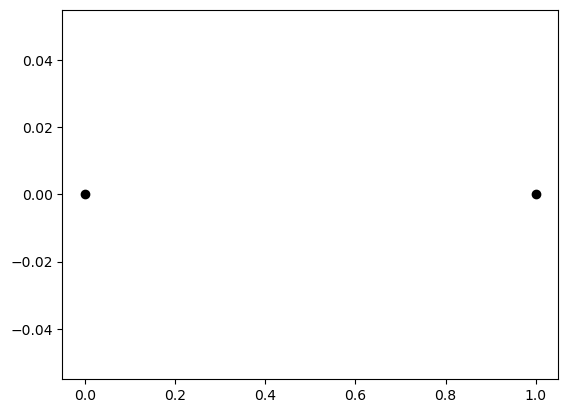

In [382]:


R_list = generate_supercell_vectors(Lx,Ly)
for i in range(2*Ly*Lx):
    plt.scatter(R_list[i, 0], R_list[i, 1], c='k')
#plt.xlim(-1, 5)
#plt.ylim(-1, 5)

In [383]:
R_list = generate_supercell_vectors(Lx,Ly)

A1 = Lx*a1
A2 = Ly*a2

def reciprocal_vectors(a1, a2):
    """Return b1, b2 for 2-D lattice defined by a1, a2."""
    area = a1[0]*a2[1] - a1[1]*a2[0]        
    b1 = 2*np.pi*np.array([ a2[1], -a2[0]])/area
    b2 = 2*np.pi*np.array([-a1[1],  a1[0]])/area
    return b1, b2

b1, b2 = reciprocal_vectors(A1, A2)


def get_NN_BZ_pts(R1, R2):
    out_list = []
    for i in [0, 1, -1]:
        for j in [0, 1, -1]:
            out_list.append(R2-R1+i*A1+j*A2)
    return out_list
      
    
#Gets the BZ point as a 1D list
def get_BZ_points(k_num):
    k_pts_list = []
    for i in range(k_num):
        for j in range(k_num):
            k_pts_list.append(b1*i/k_num + b2*j/k_num)
            #k_pts_list.append(b1*i/k_num + 3*b2*j/k_num)
            
    return k_pts_list

#Gets the BZ pts as a 2D array
def get_BZ_grid(k_num):
    BZ_grid = np.zeros(shape=(k_num, k_num, 2))
    for i in range(k_num):
        for j in range(k_num):
            BZ_grid[i, j, :] = (b1*i/k_num + b2*j/k_num)
    return BZ_grid

1.0
7.0
0.9999999999999999
7.0
16.0
3.9999999999999996
0.9999999999999999
3.9999999999999996
4.0


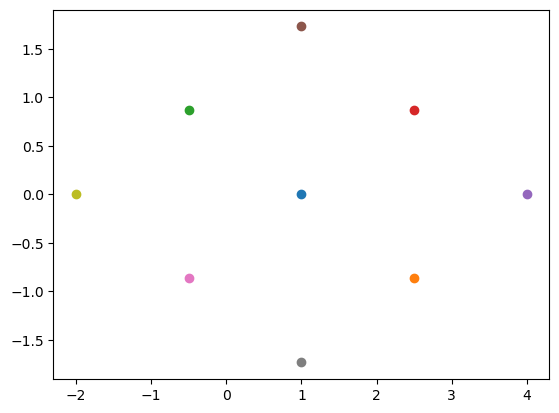

In [385]:
R1 = R_list[0, :]
R2 = R_list[1, :]


for pt in get_NN_BZ_pts(R1, R2):
    plt.scatter(pt[0], pt[1])
    print(pt@pt)

In [350]:
def H_supercell(k, t1, t2, phi_h):
    H = np.zeros(shape=(2*Lx*Ly, 2*Lx*Ly), dtype=np.complex64)
    for i in range(2*Lx*Ly):
        for j in range(2*Lx*Ly):
            R1 = R_list[i, :]
            R2 = R_list[j, :]
            
            neighbour_list = get_NN_BZ_pts(R1, R2)
            
            for pt in neighbour_list:
                if np.allclose(np.abs(pt@pt), 1):
                    H[i, j]+=-t1*np.exp(1j*np.dot(k, pt))
            for pt in neighbour_list:
                if np.allclose(np.abs(pt@pt), 3):
                    if np.any(np.all(pt == np.array([a1, -a2, a2-a1]), axis=1)):
                        H[i, j]+=-t2*np.exp(1j*np.dot(k, pt))*np.exp(1j*phi_h)
                    elif np.any(np.all(pt == -np.array([a1, -a2, a2-a1]), axis=1)):
                        H[i, j]+=-t2*np.exp(1j*np.dot(k, pt))*np.exp(-1j*phi_h)
    return H

In [351]:
def H_supercell_GPT(k, t1, t2, phi_h, tol=1e-6):
    H = np.zeros((2*Lx*Ly, 2*Lx*Ly), dtype=np.complex64)

    # Bond lengths
    a_nn = np.linalg.norm(a1)/np.sqrt(3)  # nearest-neighbor distance in honeycomb
    a_nnn = np.sqrt(3) * a_nn             # next-nearest-neighbor distance

    for i, R1 in enumerate(R_list):
        for j, R2 in enumerate(R_list):
            if i == j:
                continue

            neighbour_list = get_NN_BZ_pts(R1, R2)
            for pt in neighbour_list:
                dist = np.linalg.norm(pt)

                # --- Nearest neighbor ---
                if np.isclose(dist, a_nn, atol=tol):
                    H[i, j] += -t1 * np.exp(1j * np.dot(k, pt))

                # --- Next-nearest neighbor ---
                elif np.isclose(dist, a_nnn, atol=tol):
                    # orientation via cross product
                    # embed in 3D to compute sign
                    cross_z = np.cross([pt[0], pt[1], 0], [a1[0], a1[1], 0])[2]

                    if cross_z > 0:
                        phase = +phi_h
                    else:
                        phase = -phi_h

                    H[i, j] += -t2 * np.exp(1j * (np.dot(k, pt) + phase))

    return H


In [352]:
k_num = 30
x = np.zeros(k_num**2)
y = np.zeros_like(x)
bands = np.zeros(shape=(k_num**2, 2*Lx*Ly))

for i, k in enumerate(get_BZ_points(k_num)):
    x[i], y[i] = k
    #bands[i, :] = np.linalg.eigvalsh(H_supercell(k, t1, t2, phi_h))
    bands[i, :] = np.linalg.eigvalsh(H_supercell_GPT(k, t1, t2, phi_h))

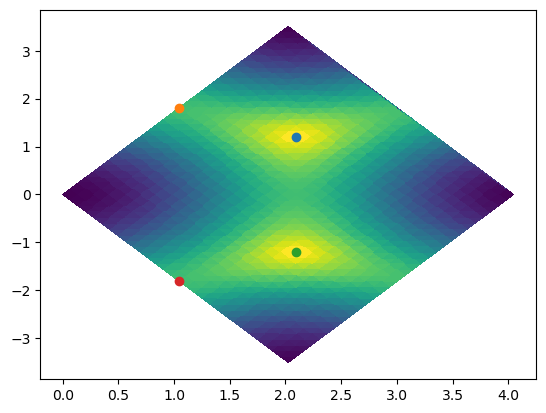

In [353]:
plt.tripcolor(x, y, bands[:, 0])
#plt.xlim(-np.pi/2, np.pi/2)
#plt.ylim(-np.pi/2, np.pi/2)

Γ = np.zeros(2)
K1 = (2*b1+b2)/3
K2 = (b1+2*b2)/3        
M1 = 0.5*b1  
M2 = 0.5*b2

plt.scatter(K1[0], K1[1])
plt.scatter(M1[0], M1[1])
plt.scatter(K2[0], K2[1])
plt.scatter(M2[0], M2[1])

In [354]:
def kpath(Nk_seg=30):
    seg1 = np.linspace(Γ, M1, Nk_seg, endpoint=False)
    seg2 = np.linspace(M1, K1, Nk_seg, endpoint=False)
    seg3 = np.linspace(K1, K2, Nk_seg, endpoint=False)
    seg4 = np.linspace(K2, Γ, Nk_seg, endpoint=True)
    return np.vstack([seg1, seg2, seg3, seg4])

In [355]:
energies = np.zeros(shape=(30*4, 2*Lx*Ly))

for i, k in enumerate(kpath()):
    energies[i, :] = np.linalg.eigvalsh(H_supercell_GPT(k, t1, t2, phi_h))

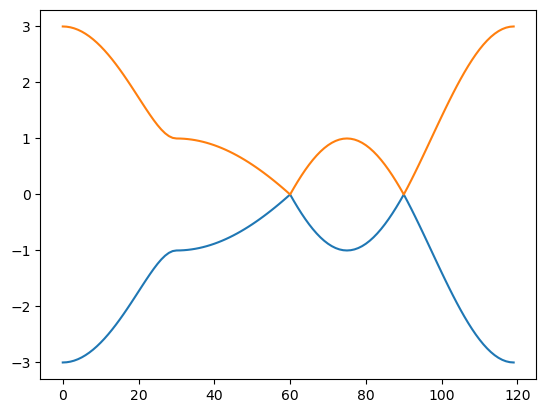

In [356]:
for i in range(2*Lx*Ly):
    plt.plot(energies[:, i])

In [277]:


os.environ["OMP_NUM_THREADS"] = "12"     # or the number of physical cores you have
os.environ["MKL_NUM_THREADS"] = "12"     # same variable if you use MKL


# Define basic sparse matrices (CSR format for efficient arithmetic)
sigma_z = sp.dia_matrix(([1, -1], 0), shape=(2, 2), dtype=complex).tocsr()
sigma_minus = sp.csr_matrix(([1], ([1], [0])), shape=(2, 2), dtype=complex)
identity = sp.eye(2, dtype=complex, format='csr')


def generate_sparse_fermionic_operators(N):
    """
    Generate sparse annihilation and creation operators for N orbitals with spin.
    
    Parameters:
    N (int): Number of orbitals.
    
    Returns:
    tuple: (annihilation_ops, creation_ops) where each is a list of 2N sparse matrices.
           The order is [orbital_0↑, orbital_0↓, orbital_1↑, orbital_1↓, ...].
    """
    
    total_modes = N
    annihilation_ops = []
    creation_ops = []
    
    for p in range(total_modes):
        # Initialize operator as a 1x1 identity matrix (to build Kronecker product)
        op = sp.eye(1, dtype=complex, format='csr')
        
        for q in range(total_modes):
            if q < p:
                term = sigma_z
            elif q == p:
                term = sigma_minus
            else:
                term = identity
            
            # Kronecker product with sparse matrices
            op = sp.kron(op, term, format='csr')
        
        annihilation_ops.append(op)
        creation_ops.append(op.conj().transpose())  # Hermitian adjoint
    
    return annihilation_ops, creation_ops

N = 2*Lx*Ly  # Number of orbitals
cs, cdags = generate_sparse_fermionic_operators(N)

In [207]:
import itertools

def get_m_basis_indices(N, M):
    """
    Generate the indices of the M-particle sector in the full Hilbert space.
    
    Parameters:
    N (int): Number of orbitals.
    M (int): Number of particles.
    
    Returns:
    list: Sorted list of indices in the full Hilbert space.
    """
    total_modes = 2 * N
    m_indices = []
    for bits in itertools.combinations(range(total_modes), M):
        index = 0
        for q in bits:
            # Reverse mode order to match the Kronecker product ordering
            pos = total_modes - 1 - q
            index += (1 << pos)
        m_indices.append(index)
    return sorted(m_indices)

# Example usage:
#N = 4
M = N-4  # Choose your desired particle number sector

# Generate the indices for the M-particle sector
m_indices = get_m_basis_indices(N//2, M)

# Assuming H is your Hamiltonian constructed as a sparse matrix in the full space
# Project H into the M-particle sector
#H_m = H[m_indices, :][:, m_indices]

# Convert to a dense matrix if needed (be cautious with memory)
# H_m_dense = H_m.toarray()

In [194]:
def hamil(t1, mu, U, t2, phi_h, k):
    hamiltonian = sp.csr_matrix((2**N, 2**N), dtype=complex)
    NN_ham_mat = H_supercell_GPT(k, t1, t2, phi_h)
    for i in range(N):
        for j in range(i+1, N):
            if NN_ham_mat[i,j] ==0: continue
            hamiltonian+=cdags[i]@cs[j]*NN_ham_mat[i,j] + cdags[j]@cs[i]*NN_ham_mat[j, i]
            hamiltonian+=cdags[i]@cs[i]@cdags[j]@cs[j]*U/(Lx*Ly)
    for i in range(N):
        hamiltonian+=-(mu)*(cdags[i]@cs[i])
    
    return hamiltonian

def n_filled(H, beta):
    #evals, evecs = full_diag_dense(H)
    evals, evecs = sp.linalg.eigsh(H, k=6, which='SA')
    Z0 = np.exp(-beta*evals).sum()
    return (np.conj(evecs.T)@num_op@ evecs*np.exp(-beta*evals)).real.sum()/Z0

from scipy.special import logsumexp

def n_filled_stable(H_csr, beta, num_op):
    #evals, evecs = full_diag_dense(H_csr)
    evals, evecs = sp.linalg.eigsh(H_csr, k=6, which='SA')
    logw = -beta * evals                       # log-weights

    Ndiag = np.diag(evecs.T.conj() @ num_op @ evecs).real
    log_num = logsumexp(logw, b=Ndiag)         # log Σ e^{-βE_i} N_ii
    log_den = logsumexp(logw)                  # log Z

    return np.exp(log_num - log_den)


def n_filled2(H, beta):
    #evals, evecs = full_diag_dense(H)
    evals, evecs = sp.linalg.eigsh(H, k=6, which='SA')
    Z0 = np.exp(-beta*evals).sum()
    return (np.conj(evecs.T)@num_op2@ evecs*np.exp(-beta*evals)).real.sum()/Z0

def n_filled_tot(t1, mu, U, t2, phi_h, beta, k_num):
    acc = 0
    for k in get_BZ_points(k_num):
        hamil_k = hamil(t1, mu, U, t2, phi_h, k)
        #H = np.asfortranarray(hamil_k.toarray(order='F')) 
        acc+=n_filled_stable(hamil_k, beta, num_op)
    return acc/k_num/k_num

def compressibility(mu, t, U, beta, k_num):
    acc = 0
    for k in get_redBZ_points(k_num):
        hamil_k = hamil(t, mu, U, k, True)
        #H = np.asfortranarray(hamil_k.toarray(order='F')) 
        #acc+=n_filled2(H, beta) -n_filled(H, beta)**2
        acc+=n_filled_stable(hamil_k, beta, num_op2) - n_filled_stable(hamil_k, beta, num_op)**2
    return acc*beta/Lx/Ly/k_num/k_num

In [281]:
num_op = sp.csr_matrix((2**N, 2**N), dtype=complex)
for i in range(N):
    num_op+=cdags[i]@cs[i]

In [283]:
k_num = 10

U_list = np.array([20])
beta_list = np.array([100])

filling_list = np.zeros(shape=(len(U_list), len(beta_list), 30))

for U_ind, U in enumerate(U_list):
    print(U)
    for beta_ind, beta in enumerate(beta_list):
        mu_list = np.linspace(0, 5, 30)
        for mu_ind, mu in enumerate(mu_list):
            filling_list[U_ind, beta_ind, mu_ind] = n_filled_tot(t1, mu, U, t2, phi_h, beta, k_num)
            print(mu_ind)

20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


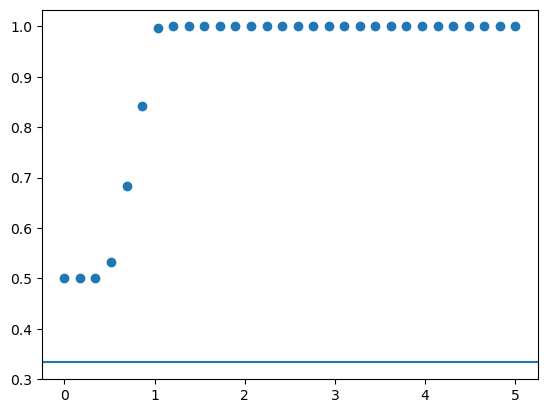

In [387]:
plt.scatter(mu_list, filling_list[0,0,:]/(2*Lx*Ly))
plt.axhline(y=0.3333)
#plt.axhline(y=0.25)

In [388]:
U = 20
beta = 100
mu = -3

N_eigs = 10

energies = np.zeros(shape=(30*4, N_eigs))

for i, k in enumerate(kpath()):
    hamil_k = hamil(t1, mu, U, t2, phi_h, k)
    evals, evecs = sp.linalg.eigsh(hamil_k, k=N_eigs, which='SA')
    energies[i, :] = np.sort(evals)

IndexError: index 2 is out of bounds for axis 1 with size 2

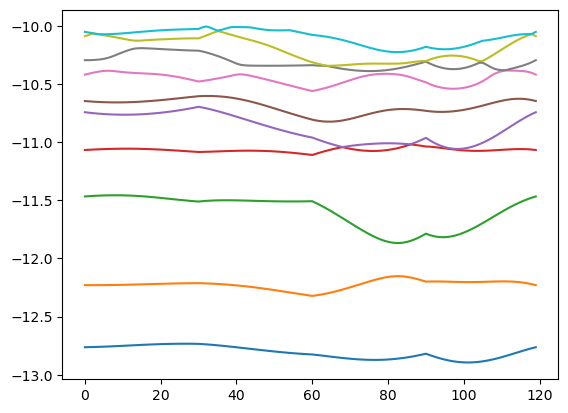

In [312]:
for i in range(N_eigs):
    plt.plot(energies[:, i])

In [198]:
U = 20
mu = 3

k_num = 20

N_eigs = 3
gs_list = []

for _ in range(5):
    gs_evec_list = np.zeros(shape=(k_num,k_num, 2**(2*Lx*Ly), N_eigs), dtype=complex)
    
    BZ_grid = get_BZ_grid(k_num)
    x, y = [], []
    
    for i in range(k_num):
        for j in range(k_num):
            k = BZ_grid[i, j, :]
            x.append(k[0])
            y.append(k[1])
            hamil_k = hamil(t1, mu, U, t2, phi_h, k)
            evals, evecs = sp.linalg.eigsh(hamil_k, k=N_eigs, which='SA')
            idx = np.argsort(evals)
            evals = evals[idx]
            evecs = evecs[:, idx]
            
            gs_evec_list[i, j, :] = evecs[:, :]

    phase=0
    particle_number = 0
    
    
    for n_evec in range(N_eigs):
        #if not n_evec == 3: continue
        for i in range(k_num):
            for j in range(k_num):
                psi1 = gs_evec_list[i, j, :, n_evec]
                psi2 = gs_evec_list[(i+1)%k_num, j, :, n_evec]
                psi3 = gs_evec_list[i, (j+1)%k_num, :, n_evec]
                psi4 = gs_evec_list[(i+1)%k_num, (j+1)%k_num, :, n_evec]

                plaq_phase = np.angle(np.vdot(psi1, psi2)*np.vdot(psi2, psi4)*np.vdot(psi4, psi3)*np.vdot(psi3, psi1)/
                                     np.abs(np.vdot(psi1, psi2)*np.vdot(psi2, psi4)*np.vdot(psi4, psi3)*np.vdot(psi3, psi1)))
                phase += plaq_phase
                particle_number+=np.vdot(psi1, num_op@psi1)

                #phase_grid.append(phase)
    print(phase/2/np.pi)

-1.0000000000000002
4.000000000000007
-2.2617277734851675e-15


KeyboardInterrupt: 